In [1]:
import torch
import torch.nn.functional as F

import torchio as tio
import matplotlib.pyplot as plt

/home/ningfei/miniforge3/envs/torch_test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("/mnt/arbeit/simon/repo/myKeymorph/")
import source
import importlib
importlib.reload(source)
from source import util

[torch.Size([1, 1, 256, 256])]


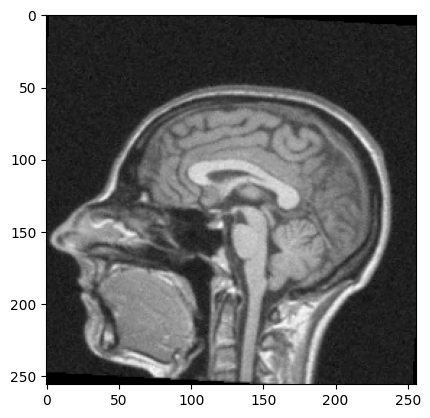

In [3]:
image_path = '/mnt/arbeit/simon/repo/myKeymorph/data/T1_sliced/IXI0000.nii'
subjects = [tio.Subject(mri=tio.ScalarImage(image_path))]
transform = tio.Compose([
            tio.ToCanonical(), 
            tio.RandomMotion(p=0.2),
            tio.RandomBiasField(p=0.3),
            tio.ZNormalization(masking_method=tio.ZNormalization.mean),
            tio.RandomNoise(p=0.5),
            tio.RandomAffine(),
            tio.RescaleIntensity(out_min_max=(0,1))
        ])
subset = tio.SubjectsDataset(subjects, transform)
loader = torch.utils.data.DataLoader(subset,1)

for img in loader:
    img_data = img['mri'][tio.DATA].float().squeeze(-1)
print([img_data.shape])
plt.imshow(img_data.squeeze().numpy(), cmap='gray')

Text(0.5, 0.98, '1.00 0.00 0.00\n0.02 1.00 0.00\n0.00 0.00 1.00')

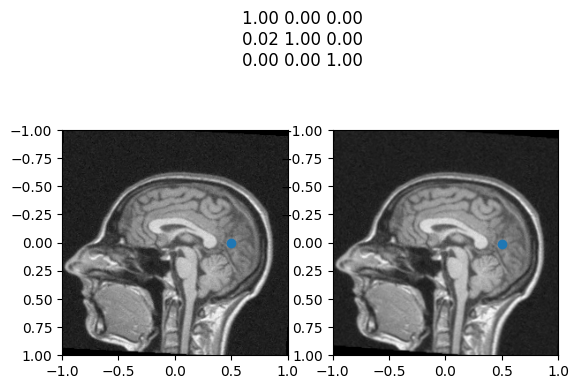

In [29]:
params = {'max_scale':0, 'max_translation':0, 'max_rotation':0, 'max_shear':0.1}
test_transform = util.AffineTransform2D()
test_transform.randomize_matrix(**params) 

transformed_img = test_transform.apply_to_img(img_data)

kp = torch.tensor((0.5,0)).reshape(1,1,2)
transformed_kp = test_transform.apply_to_kp(kp)


fig, axes = plt.subplots(1, 2)
for ax,img,kp in zip(axes,[img_data,transformed_img],[kp,transformed_kp]):
    ax.imshow(img.squeeze().numpy(), cmap='gray', origin='upper', extent=(-1,1,1,-1))
    ax.scatter(kp[0,:,0], kp[0,:,1])
fig.suptitle('%.2f %.2f %.2f\n%.2f %.2f %.2f\n%.2f %.2f %.2f' % tuple(test_transform.matrix.reshape(1,-1).squeeze().numpy().tolist()))
